## RainFall Data Analysis

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

### Download Partitioned Data

In [2]:
# Necessary metadata
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "../data/rainfall/partitions/"


# Retrieve the article metadata
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want


# Zip to Folder Unzip
files_to_dl = ["data.zip"]  # feel free to add other files here
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])
        
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)
    

### Combine Data

In [3]:
# Read the data
files_to_combine = glob.glob(output_directory + "*.csv")
files_to_combine.remove(output_directory + "observed_daily_rainfall_SYD.csv")
df = pd.concat(
    (pd.read_csv(file, index_col=0)
                .assign(model=re.findall(r'[^\/&\\]+(?=_daily_rainfall_NSW\.)', file)[0])
                for file in files_to_combine)
    )

# Save the combined data
data_path = "../data/rainfall/"
os.makedirs(data_path + "combined/", exist_ok=True)
df.to_csv(data_path + "combined/rainfall_data.csv")

In [4]:
df.head()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


In [5]:
df.tail()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
2014-12-27 12:00:00,-30.157068,-29.21466,153.125,154.375,6.689683,SAM0-UNICON
2014-12-28 12:00:00,-30.157068,-29.21466,153.125,154.375,7.862555,SAM0-UNICON
2014-12-29 12:00:00,-30.157068,-29.21466,153.125,154.375,10.005026,SAM0-UNICON
2014-12-30 12:00:00,-30.157068,-29.21466,153.125,154.375,8.541592,SAM0-UNICON
2014-12-31 12:00:00,-30.157068,-29.21466,153.125,154.375,68.117489,SAM0-UNICON


In [16]:
# get only columns time, rain, model from df
use_cols = ['time', 'rain (mm/day)', 'model']
# df_100k = pd.read_csv(data_path + "combined/rainfall_data.csv",
#                  usecols=use_cols, nrows=100_000)

df_selected = pd.read_csv(data_path + "combined/rainfall_data.csv",
                      usecols=use_cols)


In [17]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [21]:
%%time
%%R -i df_selected
start_time <- Sys.time()
suppressMessages(library(dplyr))
result <- df_selected
end_time <- Sys.time()
print(end_time - start_time)


Time difference of 0.0267961 secs
CPU times: user 10min 16s, sys: 3min 15s, total: 13min 31s
Wall time: 1h 34min 37s


In [50]:
%%R
print(nrow(result))
head(result)


[1] 62467843
                 time rain (mm/day)           model
0 1889-01-01 12:00:00  4.244226e-13 MPI-ESM-1-2-HAM
1 1889-01-02 12:00:00  4.217326e-13 MPI-ESM-1-2-HAM
2 1889-01-03 12:00:00  4.498125e-13 MPI-ESM-1-2-HAM
3 1889-01-04 12:00:00  4.251282e-13 MPI-ESM-1-2-HAM
4 1889-01-05 12:00:00  4.270161e-13 MPI-ESM-1-2-HAM
5 1889-01-06 12:00:00  4.197289e-13 MPI-ESM-1-2-HAM


In [71]:
%%R
# write R to filter by model named ACCESS-CM2
result_transformed <- result
# convert time to datetime year
result_transformed$time <- as.Date(result_transformed$time, format="%Y")
# rename column rain (mm/day) to rain
result_transformed <- rename(result_transformed, rain="rain (mm/day)")
head(result_transformed)



        time         rain           model
0 1889-03-30 4.244226e-13 MPI-ESM-1-2-HAM
1 1889-03-30 4.217326e-13 MPI-ESM-1-2-HAM
2 1889-03-30 4.498125e-13 MPI-ESM-1-2-HAM
3 1889-03-30 4.251282e-13 MPI-ESM-1-2-HAM
4 1889-03-30 4.270161e-13 MPI-ESM-1-2-HAM
5 1889-03-30 4.197289e-13 MPI-ESM-1-2-HAM


In [74]:
%%R
# group result_transformed by model and time, then sum the rain column
result_transformed_grouped <- result_transformed %>% group_by(model, time) %>% summarise(rain=sum(rain))
head(result_transformed_grouped)


`summarise()` has grouped output by 'model'. You can override using the
`.groups` argument.
# A tibble: 6 × 3
# Groups:   model [1]
  model      time         rain
  <chr>      <date>      <dbl>
1 ACCESS-CM2 1889-03-30 21443.
2 ACCESS-CM2 1890-03-30 22822.
3 ACCESS-CM2 1891-03-30 33700.
4 ACCESS-CM2 1892-03-30 31424.
5 ACCESS-CM2 1893-03-30 28611.
6 ACCESS-CM2 1894-03-30 28992.


In [75]:
%%R
# plot result
suppressMessages(library(ggplot2))
# plot rain by year facet by model
ggplot(result_transformed_grouped, aes(x=time, y=rain, colour=model)) + geom_line() + facet_grid(.~model) + theme_bw() + ggtitle("Rainfall by Year and Model") + xlab("Year") + ylab("Rainfall (mm/day)")



RParsingError: Parsing status not OK - PARSING_STATUS.PARSE_ERROR

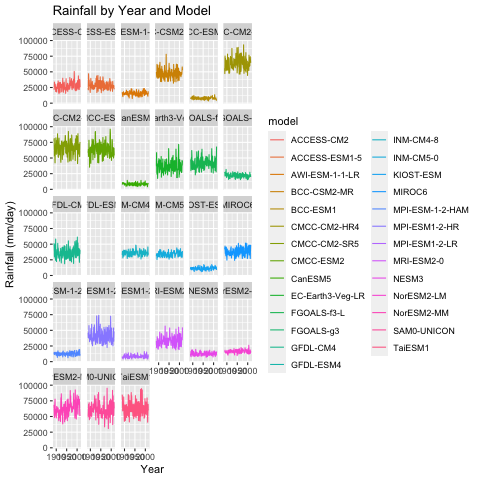

In [101]:
get_ipython().run_cell_magic(
    "R",
    "",
    '''
library(ggplot2)

ggplot(result_transformed_grouped, aes(x=time, y=rain, colour=model)) + geom_line() + facet_wrap(~model) + ggtitle("Rainfall by Year and Model") + xlab("Year") + ylab("Rainfall (mm/day)")
'''
)
